### Purpose

The purpose of this notebook is to evaluate the current approach taken to compute the PnL of a live MM agreement that includes an option component.

The current methodology to compute the PnL is to take the accumulated quote currency from delta hedging plus the value of inventory and then subtract the cost of returning the loan if it would expire now. An issue with this approach is that it is very noisy as should the option move from being out of the money to in the money there will be a sudden upswing in PnL and vice versa. 

In this notebook we look to evaluate the current option PnL computation against 3 other approaches. The first approach was proposed by the low liquidity trading team. It is similar to the current approach with the key difference being that the current inventory is valued at zero. Furthermore, an assumption is made that the loan will always be returned at the strike price and the amount returned is adjusted for by the current delta. The other two aproaches are based on assesing a risk neutral value of the traders assets and liabilities. The details of the current approach and different approaches are given in the methodology section below.

Inputs:<br />
exchange_symbol - A dictionary of the following format {exchange: {base: [quote_1, quote_2]}}. Where the base quote combinations are the symbols we are interested in analysing and exchange is the exchange these symbols trade on.<br />
minutes - An integer representing the minutes window over which resampling occurs for realized volatility computation, in this notebook set to 15.<br />
interest_rate - The annualized continuous interest rate used for pricing in the Black Scholes (BS) call pricing.<br />
tardis_instruments - A table in clickhouse which contains a mapping from tardis instrument ids to instrument ids this table must contain the instruemnt being examined in the notebook.<br />
llt_option_terms - A table in clickhouse which contains all option terms both past and present. For the symbol the user is interested in there must be an option in this table.<br />
mv_tardis_publictrades_1m - A materialized view in clickhouse which contains tardis trade data resampled to a 1 minute time frame. For the symbols and options you are interested in analyzing this data must be avalible.<br />

Outputs:<br />
trades_filt - The dataframe of the timeseries of trades that occurred for a given token with the associated pnl metric at that time for that asset class.<br />
ot_interested - The processed options terms dataframe with volatility capture.<br />

### Methodology: 

__Current Methodology:__
The current approach to computing the pnl is as follows:

\begin{equation}
\mathbf{\psi}^{c} = \mathbf{X} + \mathbf{Y}\mathbf{S} - L \, min(\mathbf{S}, K)
\end{equation}

Where:<br />
$\mathbf{\psi}^{c} = (\psi^{c}_t)_{0\leq t \leq T}$ - Is a stochastic process prepresenting the PnL of accoridng to the current methodology.<br />
$\mathbf{X} = (X_t)_{0\leq t \leq T}$ - Is a stocastic process representing the quote currency held in the portfolio from delta hedging the asset.<br />
$\mathbf{Y} = (Y_t)_{0\leq t \leq T}$ - Is a stocastic process representing the base currency held in the portfolio.<br />
$\mathbf{S} = (S_t)_{0\leq t \leq T}$ - Is a stocastic process representing the asset price.<br />
$L$ - Is the loan amount in base tokens.<br />
$K$ - Is the strike price of the loan.<br />
$t$ - Is the current time.<br />
$T$ - Is the expiration time of the loan.<br />

Throughout this notebook we do not have access to the actual timeseries of quote and base currencies. However we assume that the traders goal is to remain market neutral and is able to execute frictionlessly at the price avalible. As such $X_t$ and $Y_t$ can be written as follows:

\begin{equation}
X_t = L\bigg[\Delta_0S_0 + \int_{\Delta_0}^{\Delta_t}S_s d\Delta_s\bigg] \quad Y_t = L(1 - \Delta_t)
\end{equation}

In practicality we will be working in discrete time. As such the equivilent in discrete time is:

\begin{equation}
X_t = L  \bigg[\Delta_0S_0 + \sum_1^t(\Delta_s - \Delta_{s-1})S_s\bigg] \quad Y_t = L(1 - \Delta_t)
\end{equation}

Where:<br />
$\Delta_t$ - Is the delta at time $t$ of the implied option in the loan agreement.

__Strike Methodology:__

The first challenger methodology for computing the pnl over the lifetime of the option is called the strike methodology. This is defined as follows:

\begin{equation}
\mathbf{\psi}^{k} = \mathbf{X} - L K \mathbf{\Delta}
\end{equation}

Where:<br />
$\mathbf{\psi}^{k} = (\psi^{k}_t)_{0\leq t \leq T}$ - Is a stochastic process prepresenting the PnL of accoridng to the strike methodology.<br />
$\mathbf{\Delta} = (\Delta^{k}_t)_{0\leq t \leq T}$ - Is a stochastic process representing the delta of the implied option in the loan agreement.

It is trivial to see this is the equivilent to the current methodology with the restriction that the loan must be returned at the strike price.<br />

__Risk Neutral Methodology:__

The second challenger is the risk neutral methodology. This is defined as follows:
\begin{equation}
\mathbf{\psi}^{\mathbb{Q}} = \mathbf{X} + \mathbf{Y}\mathbf{S} - L\bigg[\mathbb{P}^{\mathbb{Q}}(\mathbf{S}| \mathbf{S} > K)K + (1 - \mathbb{P}^{\mathbb{Q}}(\mathbf{S}| \mathbf{S} > K))\mathbb{E}^{\mathbb{Q}}[\mathbf{S}| \mathbf{S} \leq K]\bigg]
\end{equation}

Where:<br />
$\mathbb{P}^{\mathbb{Q}}$ - Is the probability under the risk free measure $\mathbb{Q}$.<br />
$\mathbb{E}^{\mathbb{Q}}$ - Is the expectation under the risk free measure $\mathbb{Q}$.<br />

Under the Black Scholes framework $\mathbf{\psi}^{\mathbb{Q}}$ has a closed form solution. A key assumption of this framework is that the dynamics of $\mathbf{S}$ under the risk free measure are:

\begin{equation}
\frac{dS_t}{S_t} = rdt + \sigma dW_t
\end{equation}

Where:<br />
$\mathbf{W} = (W_t)_{0\leq t \leq T}$ - Is a Wiener process.

Under this assumption the following is given:

\begin{equation}
\mathbb{P}^{\mathbb{Q}}(\mathbf{S_t}| \mathbf{S_t} > K) = N(d_2)
\end{equation}
\begin{equation}
\mathbb{E}^{\mathbb{Q}}[\mathbf{S_t}| \mathbf{S_t} \leq K] = e^{(r + \frac{\sigma^{2}}{2})(T-t)}\frac{N(d_3)}{N(d_4)}
\end{equation}

Where:<br />
\begin{aligned}
d_{1}=\frac{ln\bigg(\frac{S_t}{k}\bigg ) + (r + \frac{\sigma^2}{2})(T-t)}{\sigma\sqrt{T-t}}\\
d_{2}=d_{1}-\sigma\sqrt{T-t}\\
d_{3}=\frac{ln\bigg(\frac{k}{S_t}\bigg) - (r + \sigma^{2})(T-t)}{\sigma\sqrt{T-t}}\\
d_{4}=d_3+\sigma\sqrt{T-t}
\end{aligned}

In terms of proofs for these result:<br />
$\mathbb{P}^{\mathbb{Q}}(\mathbf{S_t}| \mathbf{S_t} \geq K) = N(d_2)$ - Is a common result. Proof of which can be found here: https://quant.stackexchange.com/questions/44231/how-to-get-the-probability-of-exercise-call-option-in-black-scholes-model<br />
$\mathbb{E}^{\mathbb{Q}}[\mathbf{S_t}| \mathbf{S_t} \leq K] = e^{(r + \frac{\sigma^{2}}{2})(T-t)}\frac{N(d_3)}{N(d_4)}$ - Was dervived by the quant team for this specific use case. Inspiration was taken from: https://stats.stackexchange.com/questions/401309/conditional-expectation-of-log-normal-distribution. The full proof can be seen below:



$\underline{Proof:}$
Firstly, we use a change of notation to be explicit about the distribution of the random variable. We specify the problem as:<br />
\begin{equation}
\mathbb{E}^{\mathbb{Q}}[S_{t,T}| S_{t,T} \leq K]
\end{equation}

This is done to emphasise that the lifetime of the weiner process is $T-t$. $S_t$ is then the weiner process at time $t$, i.e. now, as such this is deterministic. Note then that the distribution of $S_{t,T}$ is then:

\begin{equation}
S_t e^{Z_{t,T}} \quad Z_{t,T} \sim N(r(T-t), \sigma^2(T-t))
\end{equation}

Note also that due to $S_{t,T} \geq 0$ and the natural logarithim being a monotonic function:<br />
\begin{equation}
Z_{t,T} \leq K \rightarrow S_t e^{Z_{t,T}} \leq K \rightarrow e^{Z_{t,T}} \leq \frac{K}{S_t} \rightarrow Z_{t,T} \leq ln\bigg(\frac{K}{S_t}\bigg)
\end{equation}

As such:

\begin{equation}
\mathbb{E}^{\mathbb{Q}}[S_{t,T}| S_{t,T} \leq K] = S_t\mathbb{E}^{\mathbb{Q}}\bigg[e^{Z_{t,T}} \bigg| Z_{t,T} \leq ln\bigg(\frac{K}{S_t}\bigg)\bigg] = S_t \int e^{z} f_{Z_{t,T} | Z_{t,T} \leq ln(\frac{K}{S_t})} dz
\end{equation}

Using some informal notation:<br />
\begin{equation}
f_{Z_{t,T} | Z_{t,T} \leq ln(\frac{K}{S_t})} = \frac{\mathbb{P}^{\mathbb{Q}}\bigg(Z_{t,T} = z, Z_{t,T} \leq ln(\frac{k}{S_t})\bigg)}{\mathbb{P}^{\mathbb{Q}}\bigg(Z_{t,T} \leq ln(\frac{k}{S_t})\bigg)} = \mathbb{1}_{(-\infty,ln(\frac{K}{S_t}))}(z)\bigg[ \frac{e^{\frac{-(z-r(T-t))^2}{2\sigma^2(T-t)}}}{\sqrt{2\pi\sigma^2(T-t)}}\bigg]\frac{1}{N_{r(T-t),\sigma^2(T-t)}(ln(\frac{K}{S_t}))}
\end{equation}

Where:<br />
$N_{r(T-t),\sigma^2(T-t)}$ is the normal cdf with mean of $r(T-t)$ and variance of $\sigma^2(T-t)$.

Therfore the integral becomes:<br />

\begin{equation}
\int e^{z} f_{Z_{t,T} | Z_{t,T} \leq ln(\frac{K}{S_t})} dz = \frac{1}{N_{r(T-t),\sigma^2(T-t)}(ln(\frac{K}{S_t}))} \int_{-\infty}^{ln(\frac{K}{s_t})}e^{z}\frac{e^{\frac{-(z-r(T-t))^2}{2\sigma^2(T-t)}}}{\sqrt{2\pi\sigma^2(T-t)}}dz \end{equation}

Using some algebra which can be seen in the link associated with this proof it can be proved that:<br />

\begin{equation}
z + \frac{-(z-r(T-t))^2}{2\sigma^2(T-t)} = \frac{-(z-r(T-t) + \sigma^2(T-t))^2}{\sigma^2(T-t)} + r(T-t) + \frac{\sigma^2(T-t)}{2}
\end{equation}

In order to use the result above in our proof we now define $r^* = r + \sigma^2$.

Using this these results we can arrive at the solution:<br />

\begin{aligned}
\\ \int e^{z} f_{Z_{t,T} | Z_{t,T} \leq ln(\frac{K}{S_t})} dz = \frac{1}{N_{r(T-t),\sigma^2(T-t)}(ln(\frac{K}{S_t}))} \int_{-\infty}^{ln(\frac{K}{s_t})}e^{z}\frac{e^{\frac{-(z-r(T-t))^2}{2\sigma^2(T-t)}}}{\sqrt{2\pi\sigma^2(T-t)}}dz \\ = e^{r(T-t) + \frac{\sigma^2(T-t)}{2}} \frac{1}{N_{r(T-t),\sigma^2(T-t)}(ln(\frac{K}{S_t}))} \int_{-\infty}^{ln(\frac{K}{s_t})}\frac{e^{\frac{-(z-r^{*}(T-t))^2}{2\sigma^2(T-t)}}}{\sqrt{2\pi\sigma^2(T-t)}}dz \\ = e^{r(T-t) + \frac{\sigma^2(T-t)}{2}} \frac{N_{r^{*}(T-t),\sigma^2(T-t)}(ln(\frac{K}{S_t}))}{N_{r(T-t),\sigma^2(T-t)}(ln(\frac{K}{S_t}))} \\ = e^{r(T-t) + \frac{\sigma^2(T-t)}{2}} \frac{N_{(r + \sigma^2)(T-t),\sigma^2(T-t)}(ln(\frac{K}{S_t}))}{N_{r(T-t),\sigma^2(T-t)}(ln(\frac{K}{S_t}))} \\ = e^{r(T-t) + \frac{\sigma^2(T-t)}{2}} \frac{N(d_3)}{N(d_4)}
\end{aligned}

__Pro Rated Risk Neutral Methodology:__

The third and final challenger methodology is the pro rated Risk Neutral Methodology. This takes the risk neutral methodology and looks to amortize the PnL associated with the loan over the lifetime of the option. This amortization is defined as follows:

\begin{equation}
\psi_t^{\mathbb{Q}-pr} = \frac{t\psi_t^{\mathbb{Q}}}{T}
\end{equation}

The idea behind this being that when we enter the loan agreement the risk neutral approach will recognise a large amount of PnL. This occurs as the implicit option in the loan is very valuable. However, from an accounting perspective we must provide a service over the lifetime of the laon in order to have the right to execute the option. This approach accounts for this fact and instead realizes the PnL associated with the loan over the lifetime of the loan.

### Implementation:

__Design Decisions:__
1) We resample the trade data to a given window determined by the _minutes_ variable. The price associated with this resampling window is computed using a VWAP over this time frame. If there is no trade data for a given 15 minute window linear interpolation is used to determine the price.
2) When computing the intial amount of quote currency generated by delta hedging it is assumed the base currency is sold at the current market price. If there is a large discrepency between the strike price and the inital spot price this can cause the strike and/or the current methodology for computing PnL to start at a non zero value.
3) We used the realized volatility over the lifetime of the relevant option to determine any volaitlity parameter used in this notebook, e.g. when determining the call value, delta or risk free probability PnL.

__Noteable Results:__
1) At the bottom of the graphs we also display a table showing the option terms for each market and the volatility capture. Given that we are generating a timeseries of theoretical PnL if we were to be delta hedging at each point in time one would expect the volatility capture to be zero. This is not always the case. There are two possible explanations for this: i) There is an error in the implimentation in this notebook. ii) certain assumptions regarding the black scholes model are violated on these markets. Regarding ii) Ngaio made the good point that one potential violation that could be causing this effect is non monotonic volatility/price jumps. For example if we have two price regimes one of high price one of low price and two volaitlity regimes one of high vol one of low vol. In the case that the high vol regime occurs alongside the high price regime we would have higher pnl than the option price based on the realized volatility over the period. And vice versa for the case of a high volatility regime alongside a low price regime.
2) The risk neutral PnL realizes large amounts of PnL at t=0. This is expected as explained in the methodology section. However, this inital amount is different from the black scholes call value of the option am unsure if this is an expected result.
3) The strike methodology for computing PnL is stochastically dominated by the current methodology. This also makes sense as by design the strike methodology will not note benifit from upside moves in the token as much as the current methodology.
4) Both the strike and current methodology can have instances when at $t=0$ the PnL of these approaches is greater than 0. This occurs should $S_0 > K$ as the strike methodology will assume a profit generated of $L\Delta_0(S_0 - K)$. With the current methodology assuming a profit of $L(S_0 - K)$.
5) Only the strike methodology can have a negative PnL at $t=0$ not the current methodology. This is due to similar logic as given in point 3. Specifically, if $S_0 < K$ the strike methodology will assume a loss generated of $L\Delta_0(K - S_0)$. The current methodology will simply recognise a profit of zero.
6) All PnL methodologies converge to the same terminal PnL value. This is expected as at the terminal date there should be no disagreement regarding what the PnL over the trading period is.

In [1]:
import pandas as pd
import numpy as np
from clickhouse_driver import Client
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

# display package
from IPython.display import display, HTML, Markdown
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
class LLTOptionPnL():
    
    def __init__(self):
        
        # getting the clickhouse client
        try:
            # case running in an aws instance
            if socket.gethostbyaddr(socket.gethostname())[0].split('.')[1] == 'us-east-2':
                self.host_ip = '172.31.9.89'
        
            # case running on a local instance
            else:
                self.host_ip = '3.145.11.135'
        
        except:
            # case running on a local instance
            self.host_ip = '3.145.11.135'
        
        self.client = Client(host=self.host_ip,
                             port='9000',
                             database='test',
                             user='default',
                             compression=True,
                             connect_timeout=500_000,
                             send_receive_timeout=500_000,
                             sync_request_timeout=500_000,
                             settings={'use_numpy': True}
                             )
        
        # loading in the option terms from the clickhouse
        query = '''
            select *
            from
            test.llt_option_terms
            '''
        col = [
            'name',
            'option_size',
            'base_currency',
            'quote_currency',
            'strike',
            'start_date',
            'end_date'
            ]
        
        ot = self.client.execute(query)
        self.ot = pd.DataFrame(ot, columns=col)
        # cleaning the option terms data
        self.ot = self.ot[~self.ot.duplicated()]
        self.ot = self.ot[self.ot.start_date != '']
        self.ot = self.ot[self.ot.end_date != '']
        self.ot['option_size'] = self.ot['option_size'].astype('float')
        self.ot['strike'] = self.ot['strike'].astype('float')
        self.ot['start_date'] = pd.to_datetime(self.ot.start_date.str.strip(), format='%d/%m/%Y')
        self.ot['end_date'] = pd.to_datetime(self.ot.end_date.str.strip(), format='%d/%m/%Y')
        self.ot = self.ot[self.ot.end_date < pd.Timestamp.now()]
        self.ot.sort_values('end_date', inplace=True) # useful sort for merging
        
        # loading in the tardis instruments table
        query = f'''
        select *
        from
        test.tardis_instruments
        '''
        
        cols = [
            'instrument_id',
            'exchange',
            'symbol',
            'base',
            'quote',
            'instrument_type',
            'tardis_instrument_id',
            'tardis_exchange',
            'tardis_symbol'
        ]
        
        self.instruments = pd.DataFrame(self.client.execute(query), columns = cols)
        
        # list of usd equivilents
        self.usd_stables = ['usd', 'usdt', 'usdc', 'busd']
        
        # setting seaborn plotting theme and figure size
        sns.set_theme(style="darkgrid")
        sns.set(rc={'figure.figsize':(20,4)})
    
    
    def get_trades(self, exchange_symbol: dict):
        """
        Pulls in the relevent trades from the tardis_publictrades table.
        
        Parameters
        -------
        exchange_symbol - Dictionary of the following format {exchange: {base: [quote_1, quote_2]}}.
        
        Returns
        -------
        trades - A Pandas dataframe of the trade data available in the tardis_publictrades_1m materialized view.
        """
        
        # generating the tardis instrument ids
        tardis_instrument_ids = []
        for exchange, market in exchange_symbol.items():
            for base, quotes in market.items():
                for quote in quotes:
                    tardis_instrument_ids.append(f'{exchange}_{base}_{quote}_spot')
        
        # getting the instrument id associated with these tardis instrument ids
        instruments_filt = self.instruments[self.instruments.tardis_instrument_id.isin(tardis_instrument_ids)]
        instrument_ids = instruments_filt.instrument_id.to_list()
        stingified_instrument_ids = []
        for instument in instrument_ids:
            stingified_instrument_ids.append("'" + instument + "'")

        # getting the relevent trade data
        query = f'''
        select *
        from
        test.tardis_publictrades_1m
        where
        instrument_id in ({', '.join(stingified_instrument_ids)})
        '''
        
        cols = [
            'instrument_id',
            'time_interval',
            'vwap_price',
            'total_amount'
        ]
        
        trades = pd.DataFrame(self.client.execute(query), columns = cols)
        
        # cleaning the trade data
        trades.rename(columns = {'vwap_price': 'price', 'total_amount': 'amount', 'time_interval': 'received_ts'}, inplace=True)
        trades['price'] = trades.price.astype(float)
        trades['amount'] = trades.amount.astype(float)
        trades['received_ts'] = pd.to_datetime(trades.received_ts.astype('int64'), unit = 's')
        trades.sort_values('received_ts', inplace=True)
        trades.set_index('received_ts', inplace = True)
        
        return trades[['instrument_id', 'price', 'amount']]
    
    
    def preprocess(self, exchange_symbol: dict):
        """
        Pre processes the option terms data for the markets we are interested in. Specifically, selects only the option terms
        which are relevant for the base currencies we are interested in. Will then also check to see if within the relevant option
        terms there is an option with a quote currency which is USD and within the quotes argument there is a value which
        is a usd stable coin as defined by self.usd_stables. If this is the case, for each value of usd_stable in the quotes 
        parameter the option values with a quote currency which is USD are duplicated and the quote currency replaced with 
        the relevant usd_stable value. The logic being that in the case of this analysis I assume usd stable coins are equivilent
        to USD. As such if we have say a CCDUSD option we would be interested in the realized volatility not only on CCDUSD but
        also on say CCDUSDT.
        
        Parameters
        -------
        exchange_symbol - Dictionary of the following format {exchange: {base: [quote_1, quote_2]}}.
        
        Returns
        -------
        ot_interested - The preprocessed option terms data.
        """
        
        # creating pairing of base currencies and quote currencies
        base_quote = {}
        for exchange, market in exchange_symbol.items():
            for base, quotes in market.items():
                if base in base_quote.keys():
                    base_quote[base].add(set(quotes))
                else:
                    base_quote[base] = set(quotes)
        
        ot_interested = []
        # cycling through all avalible base and quote pairing
        for base, quotes in base_quote.items():
                    
            quotes = list(quotes)
            # selecting option term data that is relevent for the market we are examining
            if pd.Series(quotes).isin(self.usd_stables).any(): 
                ot_filt = self.ot.loc[(self.ot.base_currency.str.lower() == base) & (self.ot.quote_currency.str.lower().isin(quotes+['usd']))].copy()
                
            else:  
                ot_filt = self.ot.loc[(self.ot.base_currency.str.lower() == base) & (self.ot.quote_currency.str.lower().isin(quotes))].copy()
            
            # checks for case of USD option and USD stablecoin markets
            relevant_stables = []
            for symbol in self.usd_stables:
                if symbol in quotes:
                    relevant_stables.append(symbol)

            # case of USD option and usd stablecoin markets adds rows to ot_filt for these markets
            if ((ot_filt.quote_currency == 'USD').count() > 0) and (len(relevant_stables) > 0):

                # uniformly distributes the PnL and option size between the relevant options
                num = len(relevant_stables)
                ot_filt.loc[(ot_filt.quote_currency == 'USD'),'option_size'] = ot_filt.loc[(ot_filt.quote_currency == 'USD'),'option_size']/num
                for stable in relevant_stables:

                    dup = ot_filt[ot_filt.quote_currency == 'USD'].copy()
                    dup['quote_currency'] = stable.upper()
                    ot_interested.append(dup)

            # getting relevant non usd quote markets
            relevant_riskies = []
            for quote in quotes:
                if quote not in self.usd_stables:
                    relevant_riskies.append(quote.lower())
                    
            if len(relevant_riskies) > 0:
                risky_dup = ot_filt.loc[ot_filt.quote_currency.str.lower().isin(relevant_riskies)].copy()
                ot_interested.append(risky_dup)
            
        ot_interested = pd.concat(ot_interested)
        ot_interested.sort_values(['start_date', 'quote_currency'], ascending=True, inplace=True)
        ot_interested.reset_index(inplace=True, drop=True)
            
        return ot_interested
    
    
    @staticmethod
    def generate_volatility(trades: pd.DataFrame(), ot_interested: pd.DataFrame(), minutes: int):
        """
        Generates the realized volatility statistics for the different options.
        
        Parameters
        -------
        trades - Pandas dataframe of all relevent tardis trades.
        ot_interested - The preprosessed options terms dataframe.
        minutes - The minutes window over which resampling occurs for the volatility metric.
        
        Returns
        -------
        ot_interested - The preprosessed options terms dataframe with realized volatiltiy.
        """
        
        # holds the realized vol numbers
        volatility = []
        # looping through the relevant options data
        for start_date, end_date, base, quote in zip(ot_interested['start_date'], ot_interested['end_date'], ot_interested['base_currency'], ot_interested['quote_currency']):
            
            # filtering for the relevant market for this option
            symbol = ('_' + base + '_' + quote + '_').lower()
            df_filt = trades[trades.instrument_id.str.contains(symbol)&(trades.index>=start_date)&(trades.index<=end_date)].copy()
            # deletes duplicates based on recieved ts taking the result with the lowest id and then resamples using a time window given by minutes
            # linear interpolation then used to populate the sparce dataframe of prices not needed as interpolation done in resample_trades method
            #df_filt = df_filt[~df_filt.index.duplicated()][['price']].resample(f'{minutes}T').first().interpolate('linear')
            # returns computed
            df_filt['return'] = (df_filt.price.diff()/df_filt.price.shift(1))
            # volatility is computed and annualised
            volatility.append(np.sqrt((df_filt['return']**2).sum()/(df_filt[~df_filt['return'].isna()].shape[0] - 1))*np.sqrt(365.25*24*60/minutes))
            
        ot_interested['realized_volatility'] = volatility
        
        return ot_interested[['base_currency', 'quote_currency', 'start_date', 'end_date', 'option_size', 'strike', 'realized_volatility']]
    
    
    @staticmethod
    def resample_trades(trades: pd.DataFrame(), minutes: int):
        """
        Resamples the trades data using a vwap of price and linear interpolation.
        This is done to make the actual price timesries consistent with our volatility approach and to smooth out the effect of large impact orders.
        
        Parameters
        -------
        trades - Pandas dataframe of all relevent tardis trades.
        minutes - The minutes window over which resampling occurs.
        
        Returns
        -------
        trades - The resampled trades data.
        """
        
        trades['price'] = trades.price*trades.amount
        trades = trades.groupby('instrument_id')[['price', 'amount']].resample(f'{minutes}T').sum(min_count = 1).interpolate('linear')
        trades['price'] = trades.price/trades.amount
        trades = trades.reset_index().set_index('received_ts')
        
        return trades[['instrument_id', 'price']]
    
    
    @staticmethod
    def assign_option_terms(trades: pd.DataFrame(), ot_interested: pd.DataFrame()):
        """
        Takes each trade data point and asigns an option to it.
        
        Parameters
        -------
        trades - A Pandas dataframe of the trade data available in the tardis_publictrades_1m materialized view.
        ot_interested - A Pandas Dataframe of the preprocessed option terms data.
        
        Returns
        -------
        trades - A Pandas dataframe of the trade data matched with 
        """
        
        trades['start_date'] = None
        trades['end_date'] = None
        trades['strike'] = None
        trades['option_size'] = None
        trades['base_currency'] = None
        trades['quote_currency'] = None
        trades['realized_volatility'] = None

        for oti_index, oti_row in ot_interested.iterrows():

            filt = trades.instrument_id.str.contains('_'+oti_row.base_currency.lower()+'_'+oti_row.quote_currency.lower()+'_')
            filt = filt & (trades.index >= oti_row.start_date) & (trades.index < oti_row.end_date)
            trades.loc[filt,'start_date'] = oti_row.start_date
            trades.loc[filt,'end_date'] = oti_row.end_date
            trades.loc[filt,'strike'] = oti_row.strike
            trades.loc[filt,'option_size'] = oti_row.option_size
            trades.loc[filt,'base_currency'] = oti_row.base_currency
            trades.loc[filt,'quote_currency'] = oti_row.quote_currency
            trades.loc[filt,'realized_volatility'] = oti_row.realized_volatility
        
        return trades
    
    
    @staticmethod
    def call_value(trades: pd.DataFrame(), ot_interested: pd.DataFrame, interest_rate: float):
        """
        For each relevant call option will generate the value of the call option, the delta and the accrued quote from delta hedging for each trade data.
        
        Parameters
        -------
        trades - The preprocessed trade data with relevant call option data for each trade.
        ot_interested - A Pandas Dataframe of the preprocessed option terms data.
        interest_rate - The annualized continuous interest rate.
        
        Returns
        -------
        trades_filt - The preprocessed trade data with the addition of the call value, delta and accrude quote amount. Will only include trade data that is within the
                      lifetime of the options we are analyzing.
        """
        
        # filtering out null data 
        filt = (~trades.start_date.isnull()) & (~trades.end_date.isnull()) & (~trades.strike.isnull()) & (~trades.realized_volatility.isnull())
        trades_filt = trades.loc[filt].reset_index()
        trades_filt['end_date'] = pd.to_datetime(trades_filt.end_date)
        time = (trades_filt.end_date - trades_filt.received_ts).dt.total_seconds()/(365.25*24*60*60)
        d1 = (np.log((trades_filt.price / trades_filt.strike).astype('float')) + (interest_rate + (trades_filt.realized_volatility**2)/2) * time)/(trades_filt.realized_volatility*time**(1/2))
        d2 = d1 - trades_filt.realized_volatility*time**(1/2)
        d1 = d1.astype('float')
        d2 = d2.astype('float')
        trades_filt['call_value'] = trades_filt.price*pd.Series(norm.cdf(d1)) - trades_filt.strike*np.exp(-interest_rate*time)*pd.Series(norm.cdf(d2))
        trades_filt['call_value'] = trades_filt.call_value*trades_filt.option_size
        trades_filt['delta'] = pd.Series(norm.cdf(d1))
        
        # computing the accrued quote amount from continuously delta hedging
        trades_filt['accrude_quote'] = None
        
        for oti_index, oti_row in ot_interested.iterrows():
            
            option_filt = (trades_filt.instrument_id.str.contains(oti_row.base_currency.lower()+'_'+oti_row.quote_currency.lower())) & (trades_filt.start_date == oti_row.start_date)\
                        & (trades_filt.end_date == oti_row.end_date)
            trades_filt.loc[option_filt, 'accrude_quote'] = trades_filt.loc[option_filt, 'delta'].iloc[0] * trades_filt.loc[option_filt, 'price'].iloc[0] * trades_filt.loc[option_filt, 'option_size'].iloc[0]
            trades_filt.loc[option_filt, 'accrude_quote'] += (trades_filt.loc[option_filt, 'delta'].diff().fillna(0) * trades_filt.loc[option_filt, 'price'] * trades_filt.loc[option_filt, 'option_size']).cumsum()
        
        return trades_filt
    
    
    @staticmethod
    def current_pnl_methodology(trades_filt: pd.DataFrame()):
        """
        Will generate the PnL according to our current approach of immediate expiration.
        
        Parameters
        -------
        trades_filt - The preprocessed trade data with the addition of the call value, delta and accrude quote amount. Will only include trade data that is within the
                      lifetime of the options we are analyzing.
        
        Returns
        -------
        trades_filt - The preprocessed trade data with the addition of the PnL for the relevant option based on the current PnL approach.
        """
        
        # value of quote currency from delta hedging and marked to market inventory of base quote
        trades_filt['current_pnl'] = trades_filt.accrude_quote + (1-trades_filt.delta)*trades_filt.option_size*trades_filt.price
        in_money_filt = (trades_filt.price >= trades_filt.strike)
        # case of being in the money if expiration occured now
        # return loan at strike price
        trades_filt.loc[in_money_filt, 'current_pnl'] -= trades_filt.loc[in_money_filt, 'option_size'] * trades_filt.loc[in_money_filt, 'strike']
        # case of being out the money if expiration occured now
        # return loan in stock
        trades_filt.loc[~in_money_filt, 'current_pnl'] -= trades_filt.loc[~in_money_filt, 'option_size'] * trades_filt.loc[~in_money_filt, 'price']
        
        return trades_filt
    
    
    @staticmethod
    def strike_pnl_methodology(trades_filt: pd.DataFrame()):
        """
        Generates the PnL according to a strike methodology. Defined as the revenue generated by delta hedging - delta*option_size*strike.
        
        Parameters
        -------
        trades_filt - The preprocessed trade data with the addition of the call value, delta and accrude quote amount. Will only include trade data that is within the
                      lifetime of the options we are analyzing.
                      
        Returns
        -------
        trades_filt - The preprocessed trade data with the ddition of the PnL for the relevant option based on the strike PnL approach.
        """
        
        trades_filt['strike_pnl'] = trades_filt.accrude_quote - trades_filt.delta * trades_filt.option_size * trades_filt.strike
        
        return trades_filt
    
    
    @staticmethod
    def probability_pnl_methodology(trades_filt: pd.DataFrame(), ot_interested: pd.DataFrame(), interest_rate: float):
        """
        Generates the PnL according to the risk neutral probability PnL approach.
        
        Parameters
        -------
        trades_filt - The preprocessed trade data with the addition of the call value, delta and accrude quote amount. Will only include trade data that is within the
                      lifetime of the options we are analyzing.
                      
        Returns
        -------
        trades_filt - The preprocessed trade data with the addition of the PnL for the relevant option based on the risk neutral probability PnL approach.
        """
        
        # computing the probability of option execution i.e. P[S>K]
        time = (trades_filt.end_date - trades_filt.received_ts).dt.total_seconds()/(365.25*24*60*60)
        trades_filt['time_to_expiration'] = time
        d1 = (np.log((trades_filt.price / trades_filt.strike).astype('float')) + (interest_rate + trades_filt.realized_volatility**2/2)*trades_filt.time_to_expiration)/(trades_filt.realized_volatility*trades_filt.time_to_expiration**(1/2))
        d2 = d1 - trades_filt.realized_volatility*trades_filt.time_to_expiration**(1/2)
        d2 = d2.astype('float')
        trades_filt['d2'] = d2
        trades_filt['prob_execution'] = norm.cdf(d2)
        
        # computing expected price of token conditional on token value being less than strike price i.e. E[S | S < K]
        d3 = (np.log((trades_filt.strike/trades_filt.price).astype('float')) - (interest_rate + trades_filt.realized_volatility**2) * trades_filt.time_to_expiration) / (trades_filt.realized_volatility * trades_filt.time_to_expiration**(1/2))
        d4 = d3 + trades_filt.realized_volatility * trades_filt.time_to_expiration**(1/2)
        d3 = d3.astype('float')
        d4 = d4.astype('float')
        
        trades_filt['multiplier'] = np.exp((interest_rate + (trades_filt.realized_volatility.astype('float')**2)/2 ) * time.astype('float'))
        trades_filt['cdf_d3'] = norm.cdf(d3)
        trades_filt['cdf_d4'] = norm.cdf(d4)
        # edge case when very negative d3 and d4
        zero_error = (trades_filt.cdf_d3 == 0) & (trades_filt.cdf_d4 == 0)
        
        trades_filt.loc[~zero_error, 'ratio'] = trades_filt.loc[~zero_error, 'cdf_d3'] / trades_filt.loc[~zero_error, 'cdf_d4']
        trades_filt.loc[zero_error, 'ratio'] = 1
        trades_filt['conditional_price'] = np.exp((interest_rate + (trades_filt.realized_volatility.astype('float') ** 2)/2 ) * time.astype('float')) * trades_filt.ratio
        trades_filt['conditional_price'] *= trades_filt.price
        
        # computing risk free probability profit 
        trades_filt['gross_cost'] = trades_filt.option_size * (trades_filt.strike * trades_filt.prob_execution + (1 - trades_filt.prob_execution) * trades_filt.conditional_price)
        trades_filt['gross_revenue'] = trades_filt.accrude_quote + trades_filt.option_size * (1 - trades_filt.delta) * trades_filt.price
        trades_filt['probability_pnl'] = trades_filt.gross_revenue - trades_filt.gross_cost
        
        # computing pro-rated risk free probability profit 
        trades_filt['inital_time'] = None
        for oti_index, oti_row in ot_interested.iterrows():
            
            filt = (trades_filt.instrument_id.str.contains(oti_row.base_currency.lower()+'_'+oti_row.quote_currency.lower())) & (trades_filt.start_date == oti_row.start_date)\
                        & (trades_filt.end_date == oti_row.end_date)
            trades_filt.loc[filt,'inital_time'] = trades_filt[filt].time_to_expiration.iloc[0]
            
        trades_filt['pro_rata_probability_pnl'] = trades_filt.probability_pnl * (1 - trades_filt.time_to_expiration/trades_filt.inital_time)
        
        return trades_filt
    
    
    @staticmethod
    def plotting(trades_filt: pd.DataFrame(), ot_interested: pd.DataFrame()):
        """
        Creates relevant plots for all instruments.
        
        Parameters
        -------
        trades_filt - The preprocessed trade data with all PnL methodologies.
        ot_interested - The preprosessed options terms dataframe.
        
        Returns
        -------
        None
        """
        
        # looping through the relevant options data
        for start_date, end_date, base, quote in zip(ot_interested['start_date'], ot_interested['end_date'], ot_interested['base_currency'], ot_interested['quote_currency']):

            # filtering for the relevant market for this option
            symbol = ('_' + base + '_' + quote + '_').lower()
            filt = trades_filt.instrument_id.str.contains(symbol)&(trades_filt.received_ts>=start_date)&(trades_filt.received_ts<end_date)

            # doing the relevant plotting
            fig = plt.figure()
            plt.rc('legend', fontsize = 7)
            plt.subplot(121)
            ax = sns.lineplot(x = 'received_ts', y = 'call_value', legend=False, color='blue', data = trades_filt[filt], label='Call Value')
            ax2 = ax.twinx()
            ax2.grid(None)
            sns.lineplot(x='received_ts', y='price', ax=ax2, data = trades_filt[filt], legend=False, color="red", label='Token Price')
            sns.lineplot(x='received_ts', y='strike', ax=ax2, data = trades_filt[filt], legend=False, color="green", label='Strike Price')
            ax.set_xlabel("Datetime")
            ax.set_ylabel(r"Call Value")
            ax2.set_ylabel(r"Token Price")
            ax.set_title('Spot Price, Call Value and Strike')
            ax.set_xticks(ax.get_xticks()[::2])

            plt.subplot(122)
            ax = sns.lineplot(x = 'received_ts', y = 'probability_pnl', legend=False, color='orange', data = trades_filt[filt], label='Risk Neutral')
            sns.lineplot(x='received_ts', y='current_pnl', ax=ax, data = trades_filt[filt], legend=False, color="purple", label='Current')
            sns.lineplot(x='received_ts', y='strike_pnl', ax=ax, data = trades_filt[filt], legend=False, color="black", label='Strike')
            sns.lineplot(x='received_ts', y='pro_rata_probability_pnl', ax=ax, data = trades_filt[filt], legend=False, color="brown", label='Pro Rata Risk Neutral')
            ax2 = ax.twinx()
            ax2.grid(None)
            sns.lineplot(x='received_ts', y='current_vol_capture', ax=ax2, data = trades_filt[filt], legend=False, color="purple", label='_nolegend_')
            sns.lineplot(x='received_ts', y='strike_vol_capture', ax=ax2, data = trades_filt[filt], legend=False, color="black", label='_nolegend_')
            sns.lineplot(x='received_ts', y='probability_vol_capture', ax=ax2, data = trades_filt[filt], legend=False, color="orange", label='_nolegend_')
            sns.lineplot(x='received_ts', y='pro_rata_probability_vol_capture', ax=ax2, data = trades_filt[filt], legend=False, color="brown", label='_nolegend_')
            ax2.set_ylabel(r"Volatility Capture")
            ax.set_xlabel("Datetime")
            ax.set_ylabel(r"PnL")
            ax.set_title('PnL Methodologies')
            ax.set_xticks(ax.get_xticks()[::2])

            fig.suptitle(f'{base.upper()}/{quote.upper()} {start_date.date()} - {end_date.date()}', fontsize=16)
            fig.legend(loc="upper right")
            plt.subplots_adjust(wspace=0.4)
            plt.show()
            
            
    @staticmethod
    def vol_capture(trades_filt: pd.DataFrame(), ot_interested: pd.DataFrame()):
        """
        Generates the volatility capture. This should be 1 if the black scholes assumptions hold.
        
        Parameters
        -------
        trades_filt - The preprocessed trade data with all PnL methodologies and the call price.
        ot_interested - The preprosessed options terms dataframe.
        
        Returns
        -------
        ot_interested - The preprosessed options terms dataframe with the volatility capture.
        """
        
        vol_capture = []
        inital_price = []
        
        for start_date, end_date, base, quote in zip(ot_interested['start_date'], ot_interested['end_date'], ot_interested['base_currency'], ot_interested['quote_currency']):

            # filtering for the relevant market for this option
            symbol = ('_' + base + '_' + quote + '_').lower()
            filt = trades_filt.instrument_id.str.contains(symbol)&(trades_filt.received_ts>=start_date)&(trades_filt.received_ts<end_date)
            
            vol_capture.append(trades_filt[filt].iloc[-1]['current_pnl']/trades_filt[filt].iloc[0]['call_value'])
            inital_price.append(trades_filt[filt].iloc[-1]['price'])
            
            trades_filt.loc[filt,'current_vol_capture'] = trades_filt.loc[filt,'current_pnl']/trades_filt[filt].iloc[0]['call_value']
            trades_filt.loc[filt,'strike_vol_capture'] = trades_filt.loc[filt,'strike_pnl']/trades_filt[filt].iloc[0]['call_value']
            trades_filt.loc[filt,'probability_vol_capture'] = trades_filt.loc[filt,'probability_pnl']/trades_filt[filt].iloc[0]['call_value']
            trades_filt.loc[filt,'pro_rata_probability_vol_capture'] = trades_filt.loc[filt,'pro_rata_probability_pnl']/trades_filt[filt].iloc[0]['call_value']
            
        ot_interested['volatility_capture'] = vol_capture
        ot_interested['inital_price'] = inital_price
        
        return ot_interested
    
    
    def display_pnl_methods(self, exchange_symbol: dict, interest_rate: float, minutes: int):
        """
        Convenient wrapper to call methods in correct order to generate the PnL analysis.
        
        Parameters
        -------
        exchange_symbol - Dictionary of the following format {exchange: {base: [quote_1, quote_2]}}.
        interest_rate - The annualized continuous interest rate.
        minutes - The minutes window over which resampling occurs.
        
        Returns
        -------
        ot_interested - The processed options terms dataframe.
        trades_filt - The processed trade data.
        """
        
        # generating relevant data
        trades = self.get_trades(exchange_symbol)
        trades = self.resample_trades(trades, minutes)
        ot_interested = self.preprocess(exchange_symbol)
        ot_interested = self.generate_volatility(trades, ot_interested, minutes)
        trades = self.assign_option_terms(trades, ot_interested)
        trades_filt = self.call_value(trades, ot_interested, interest_rate)
        trades_filt = self.current_pnl_methodology(trades_filt)
        trades_filt = self.strike_pnl_methodology(trades_filt)
        trades_filt = self.probability_pnl_methodology(trades_filt, ot_interested, interest_rate)
        ot_interested = self.vol_capture(trades_filt, ot_interested)
        
        ot_interested.sort_values(['base_currency', 'end_date'], inplace=True)
        #displaying PnL graphs
        self.plotting(trades_filt, ot_interested)
        
        # displaying volatility capture
        display(Markdown(f"### Theotetical maximum volatility capture:"))
        display(ot_interested[['base_currency','quote_currency','start_date','end_date', 'inital_price', 'strike', 'volatility_capture']].sort_values(['base_currency', 'end_date']))
        
        return ot_interested, trades_filt

In [6]:
exchange_symbol = {
    'okex': {
        'velo': ['usdt']
    },
    'binance': {
        'ant': ['usdt', 'btc']
    },
    'bitfinex': {
        'ccd': ['usd', 'usdt', 'btc']
    }
}
interest_rate = 0
minutes = 15

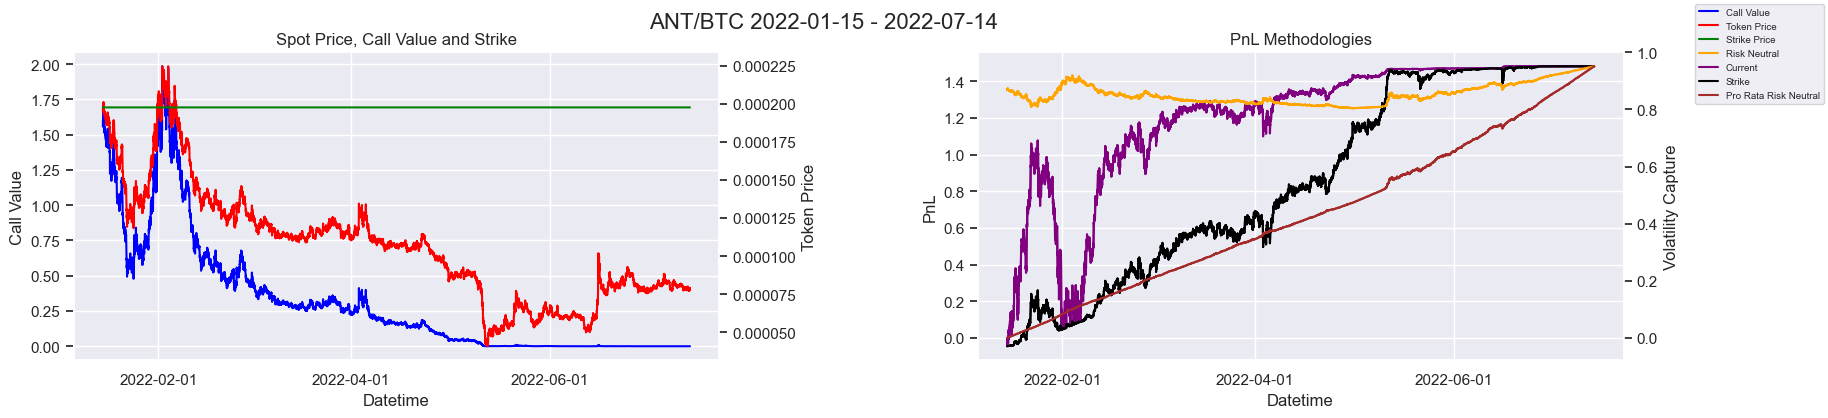

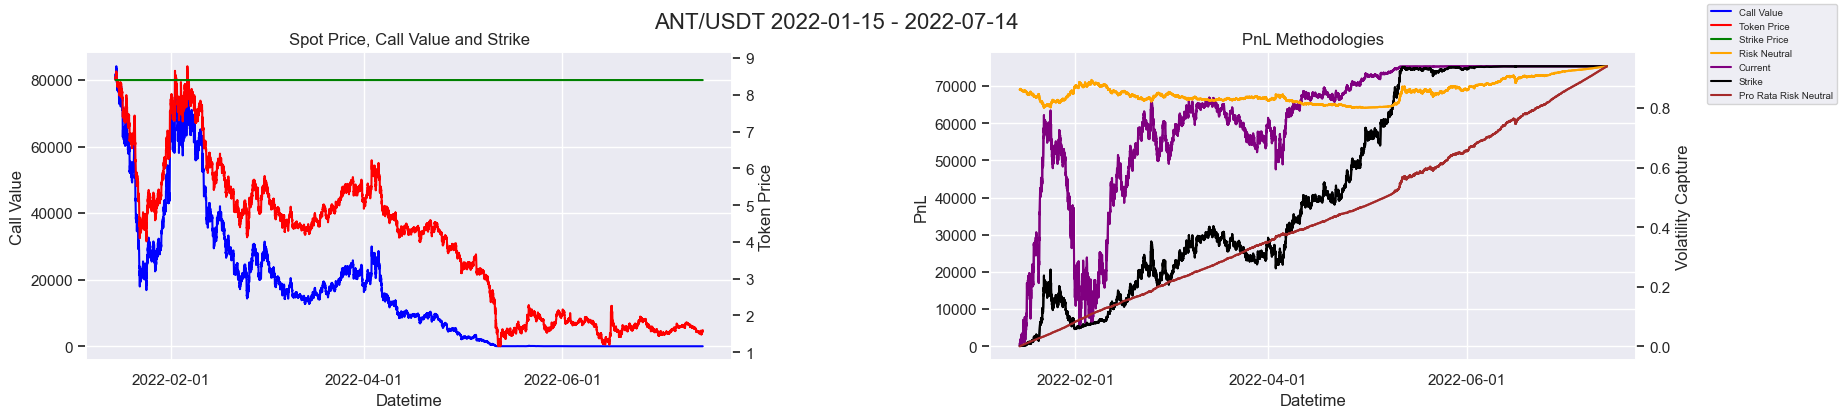

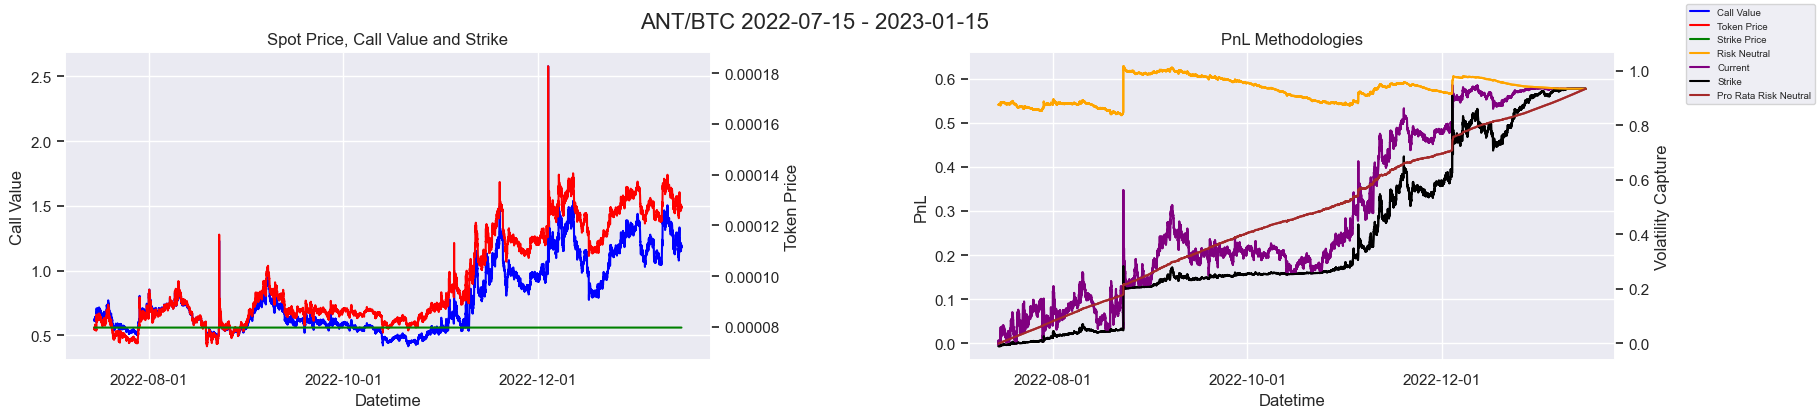

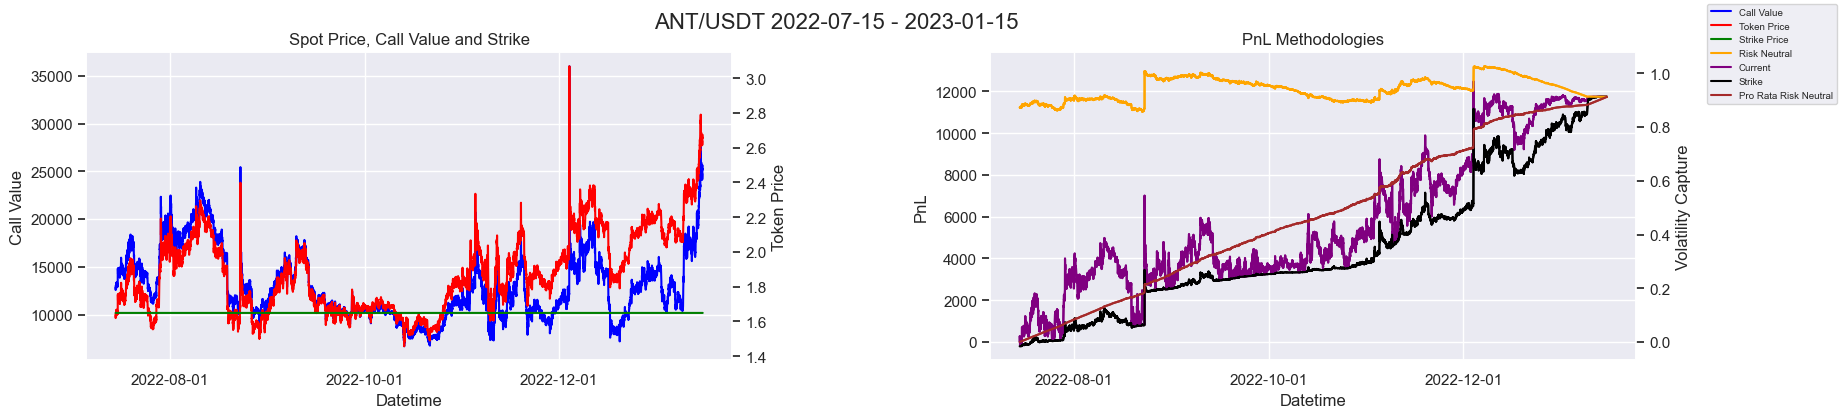

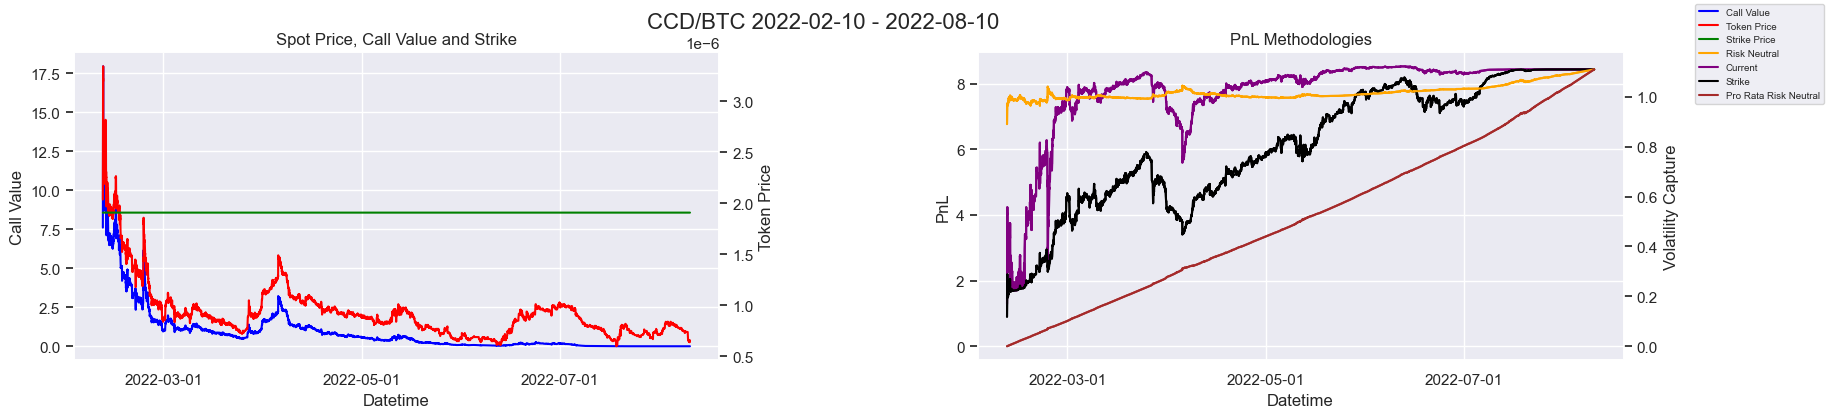

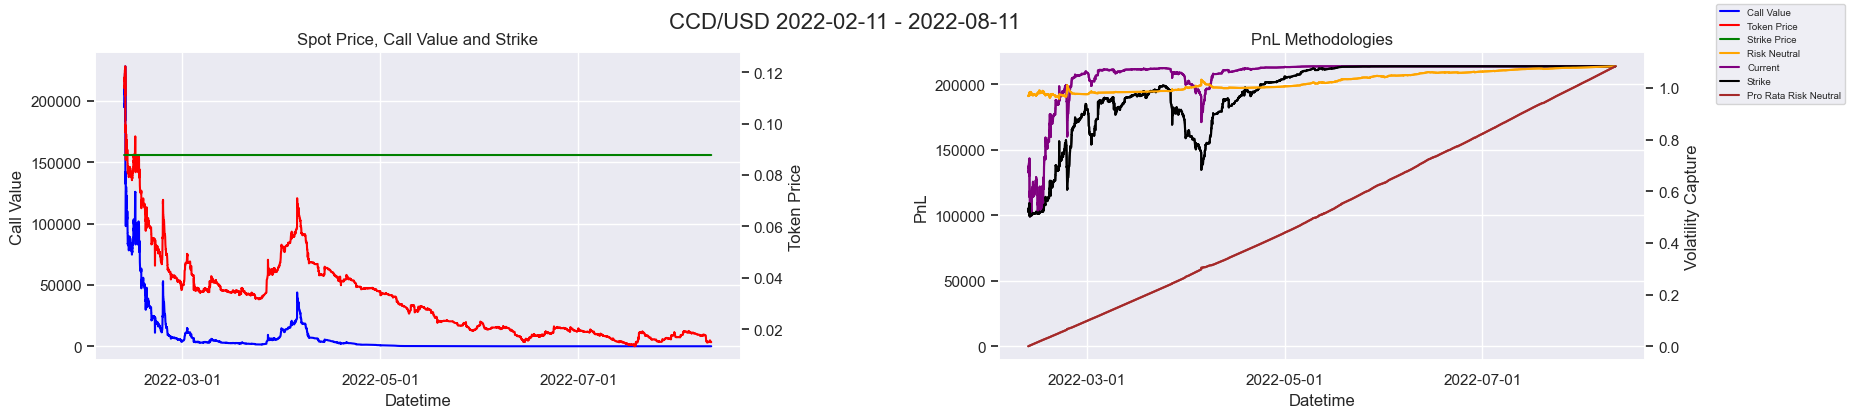

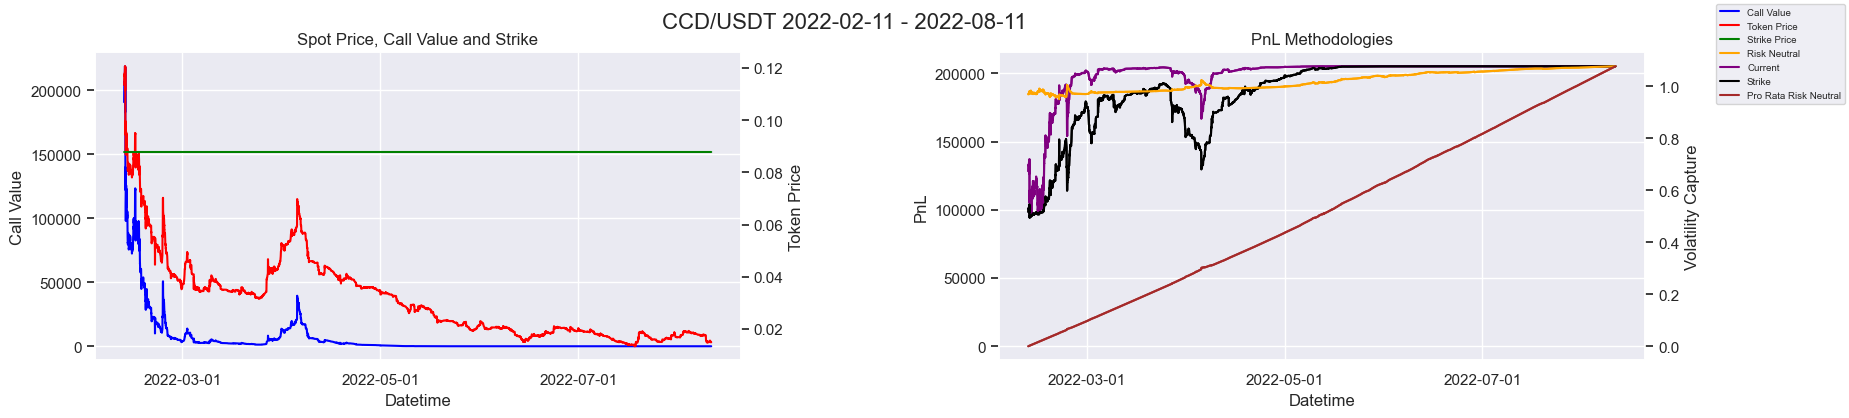

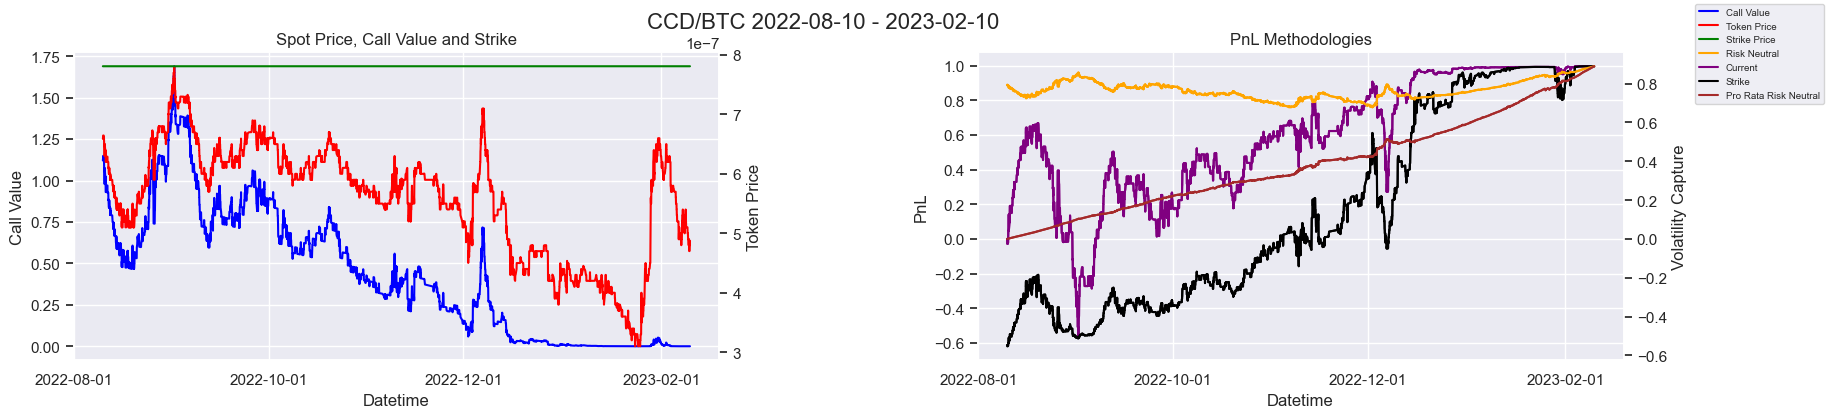

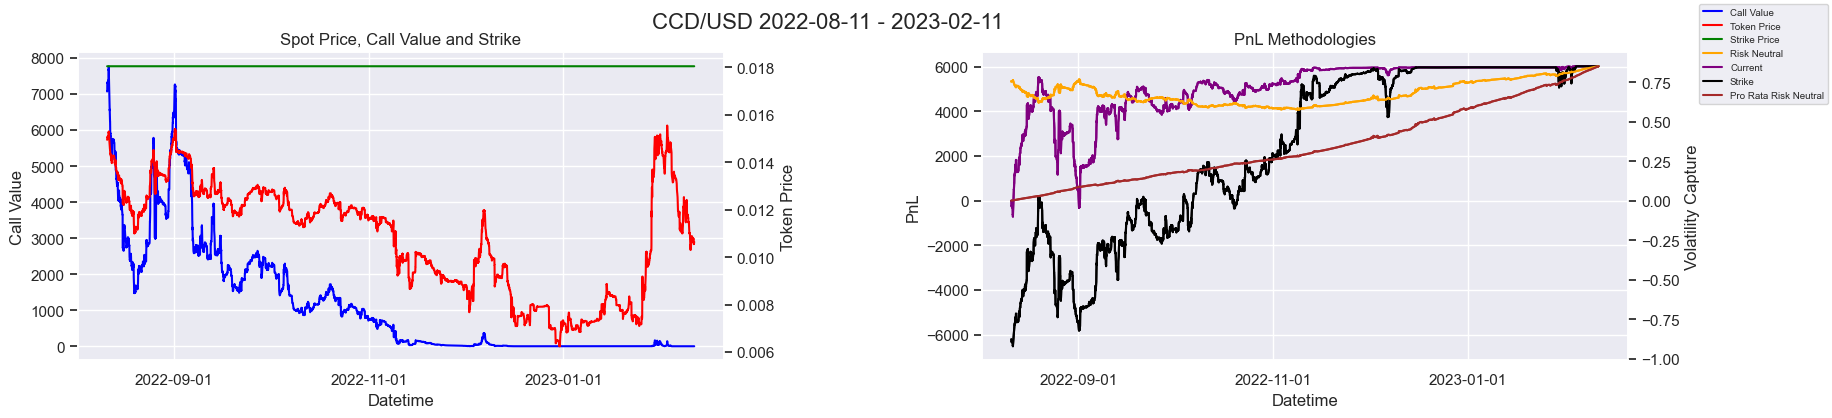

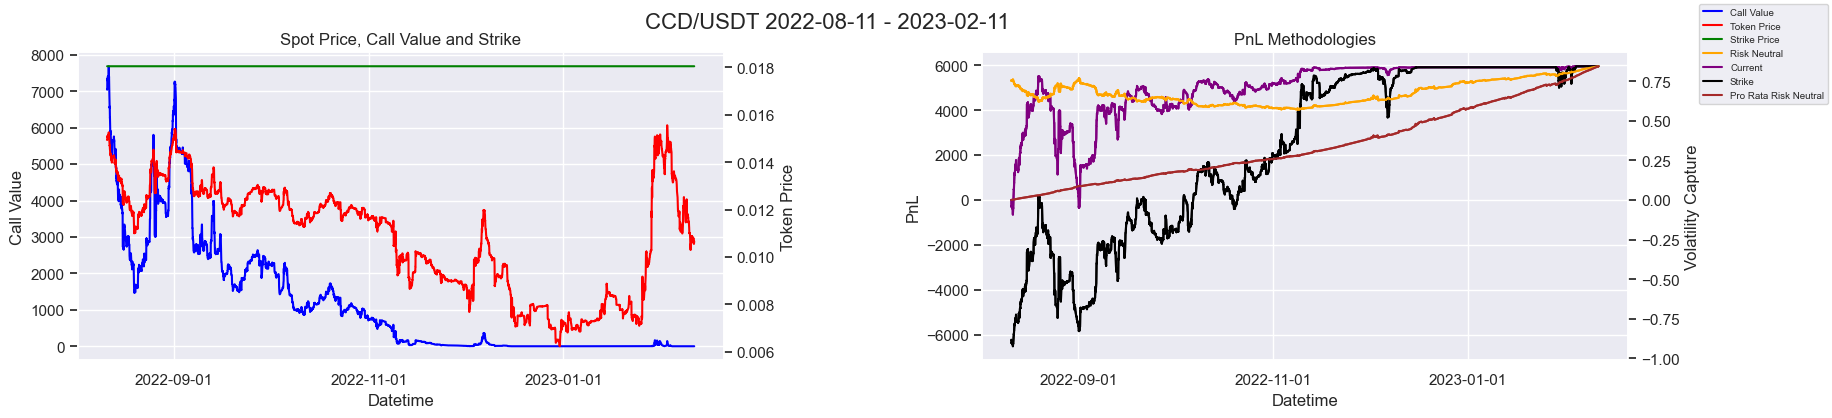

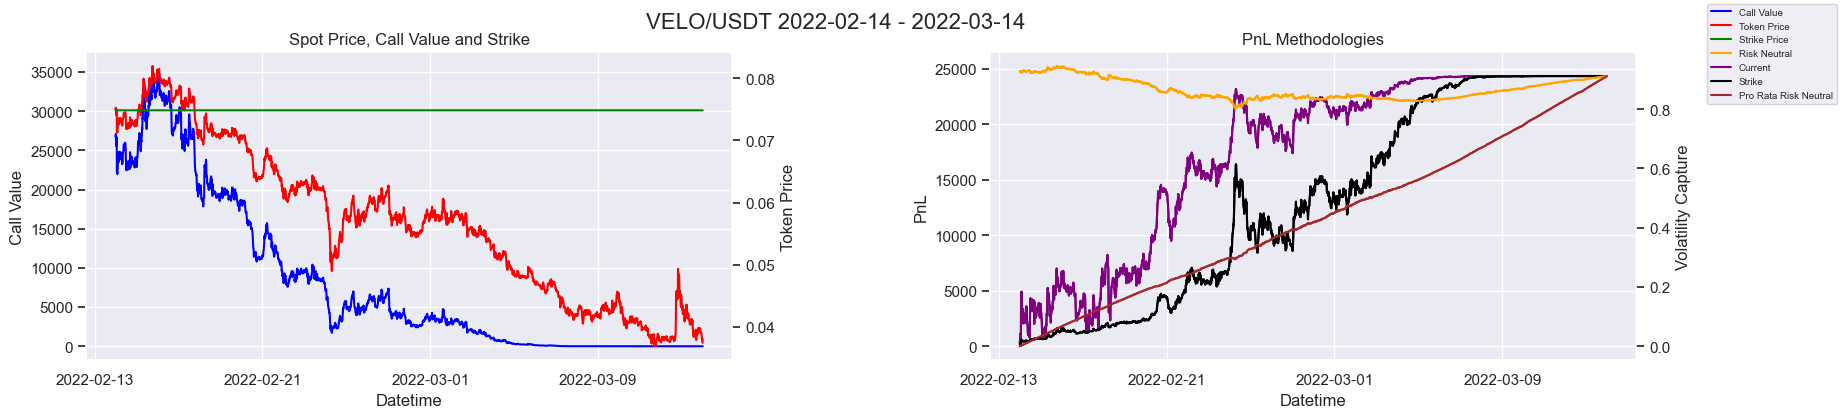

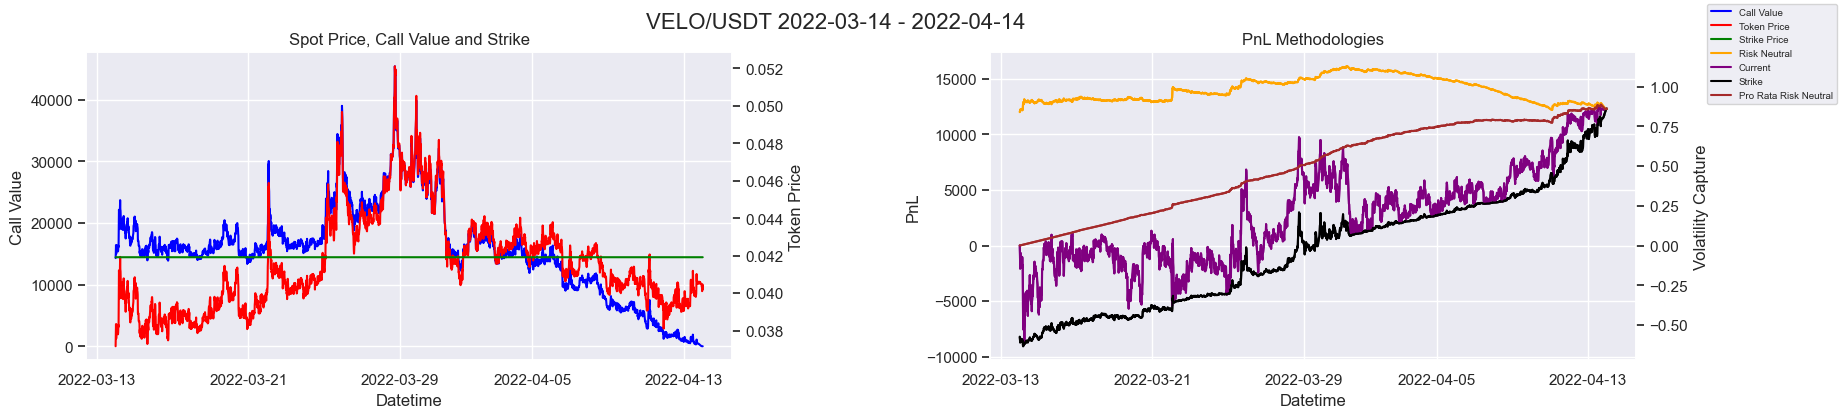

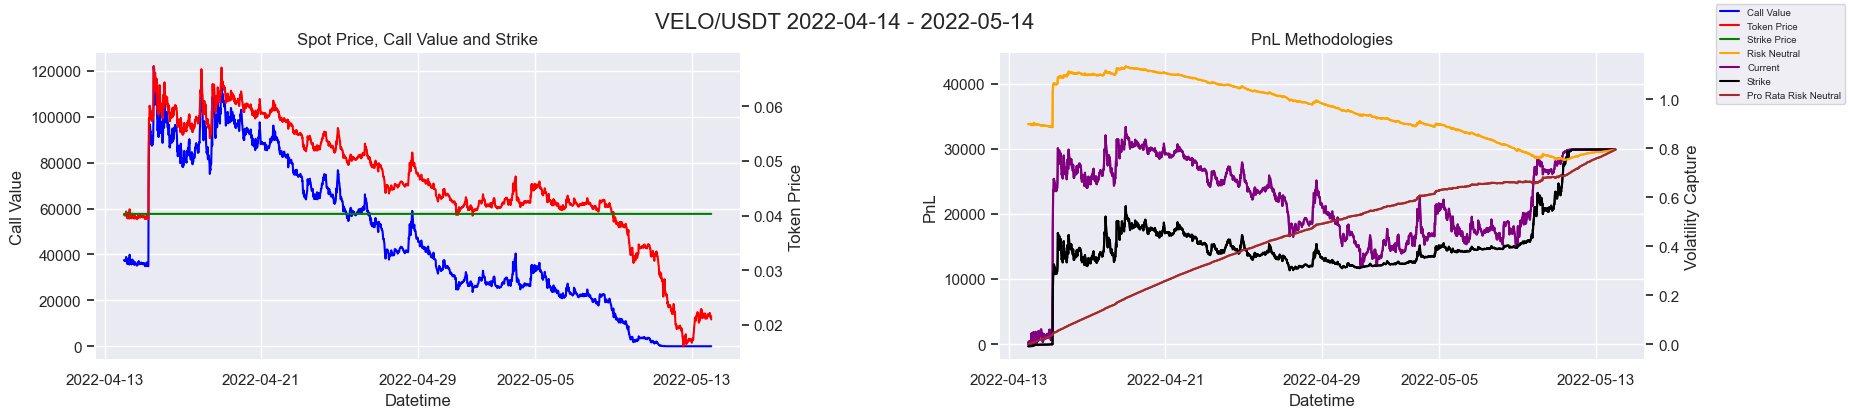

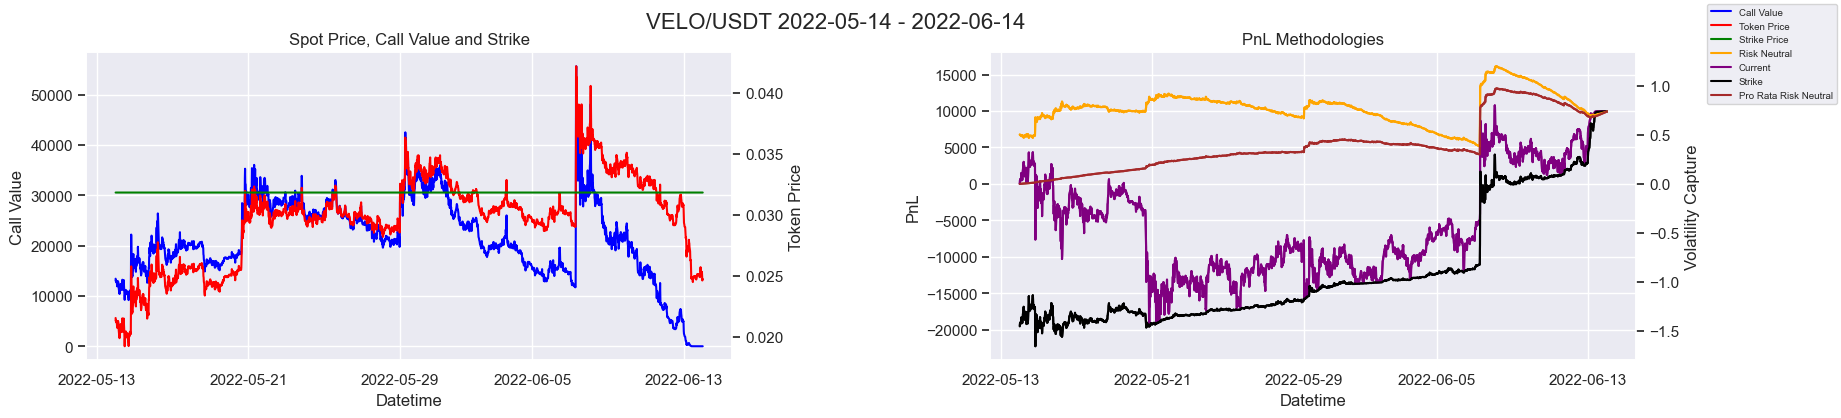

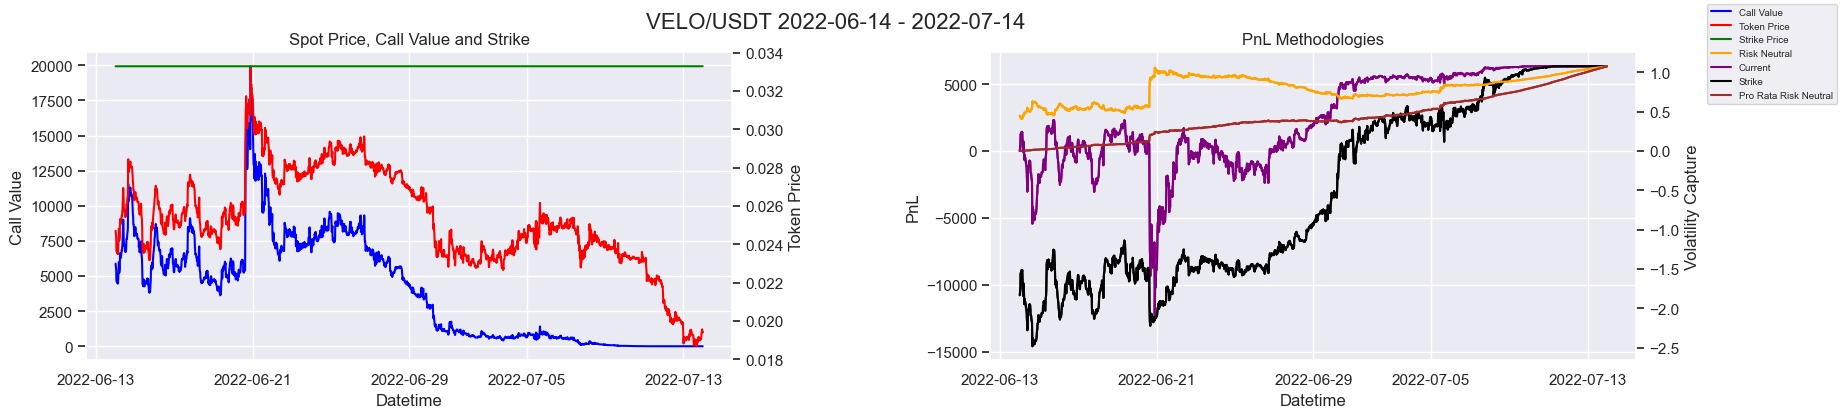

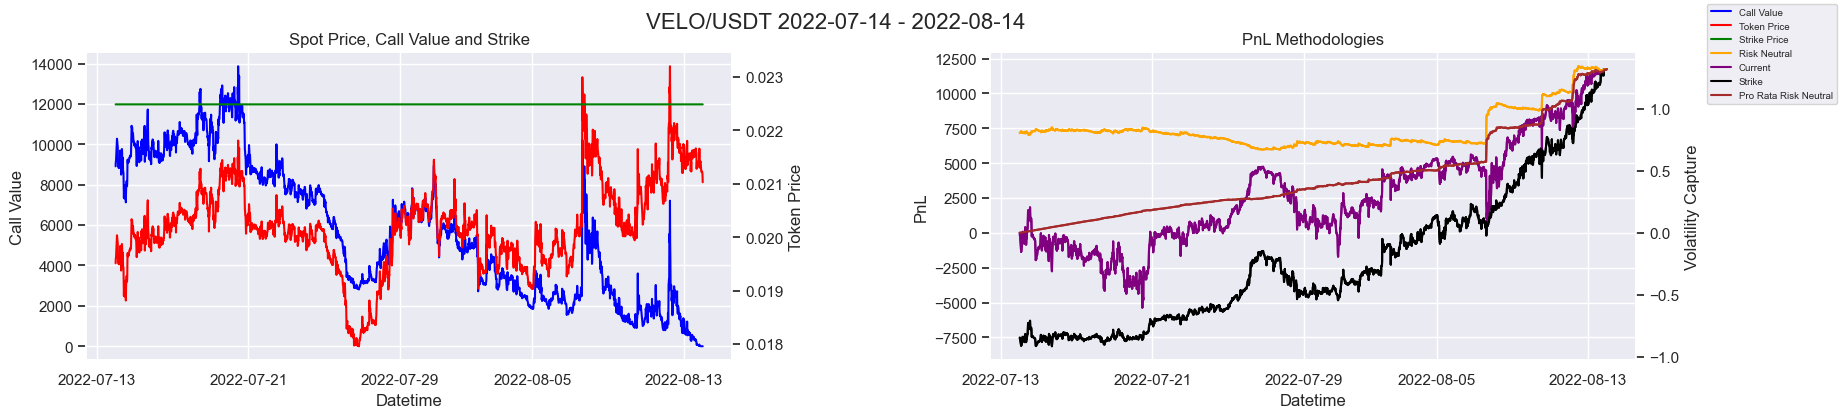

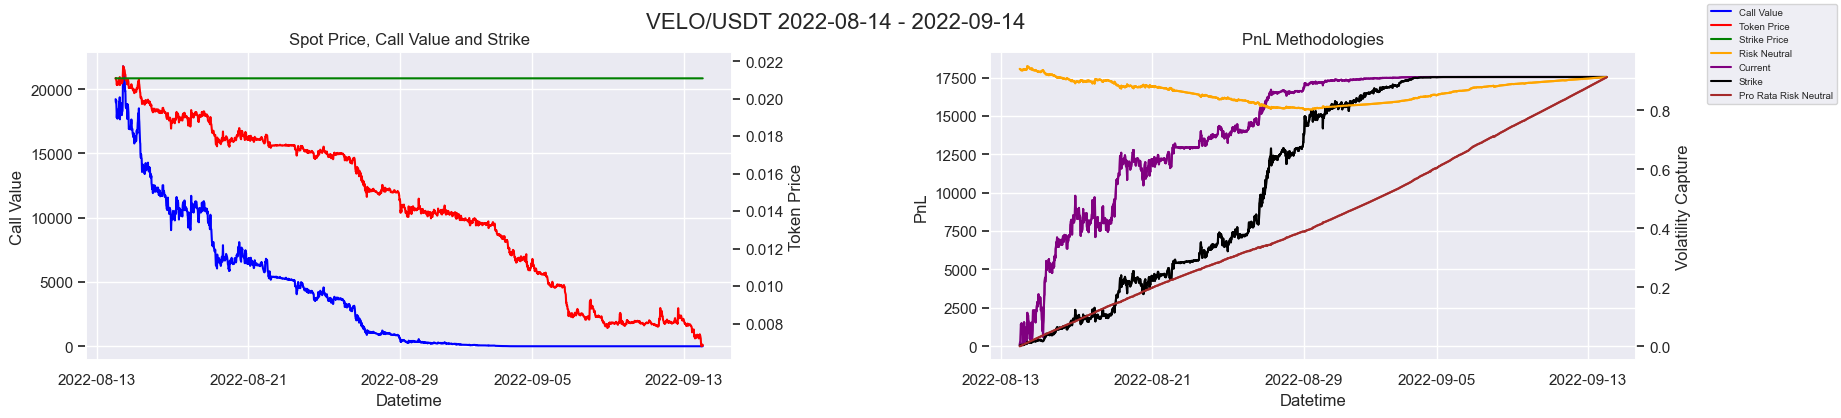

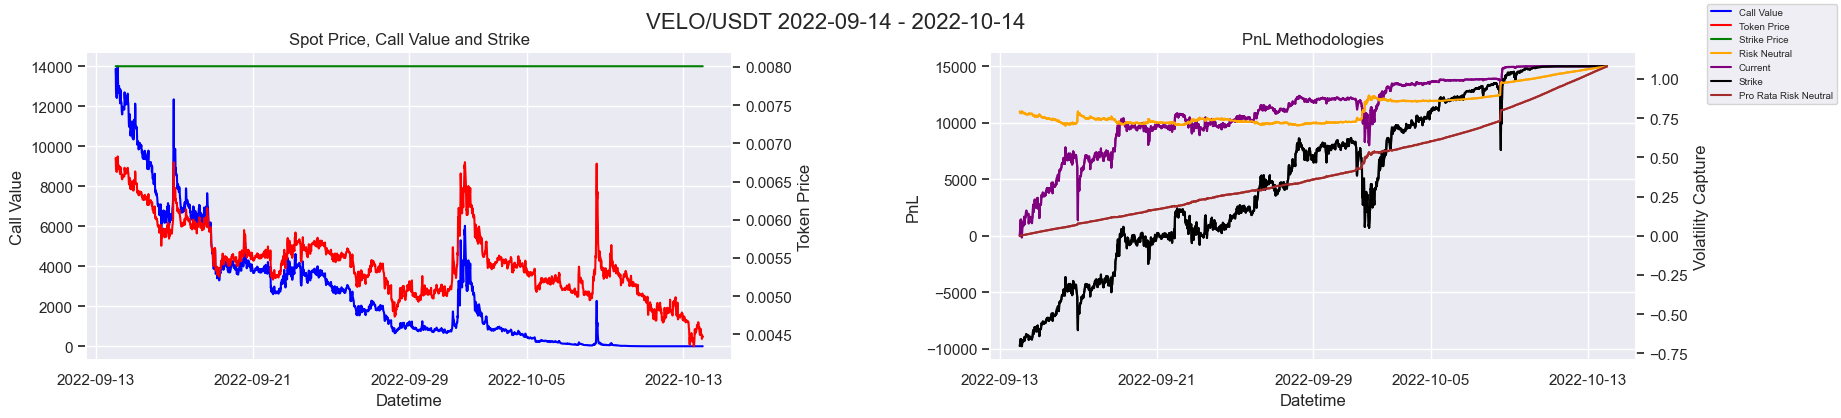

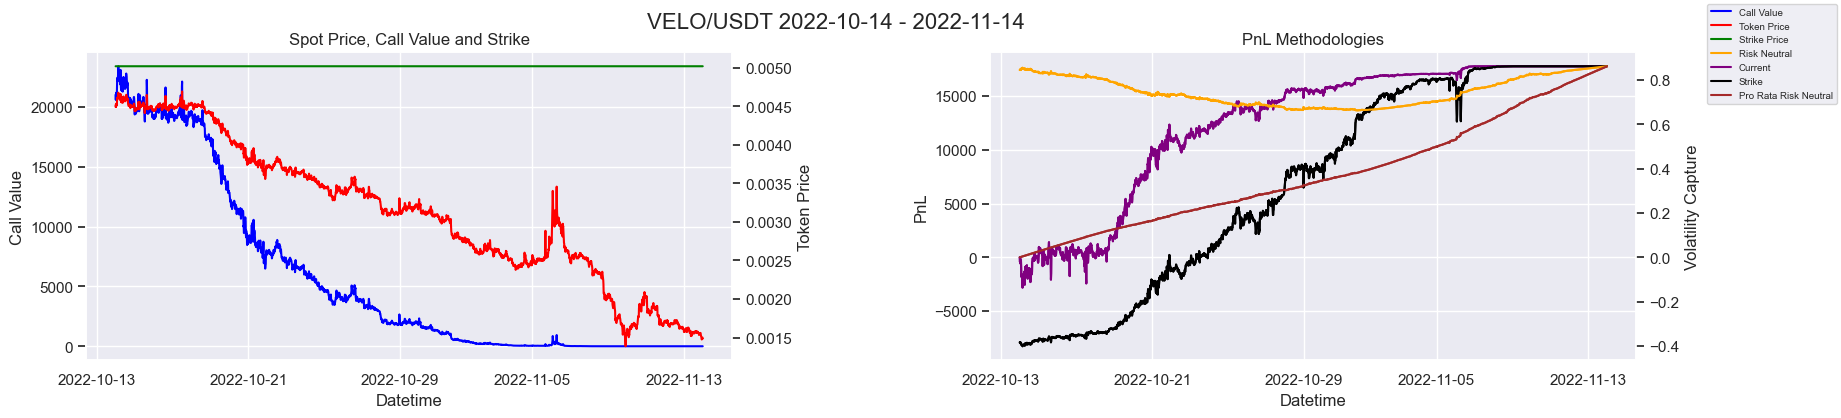

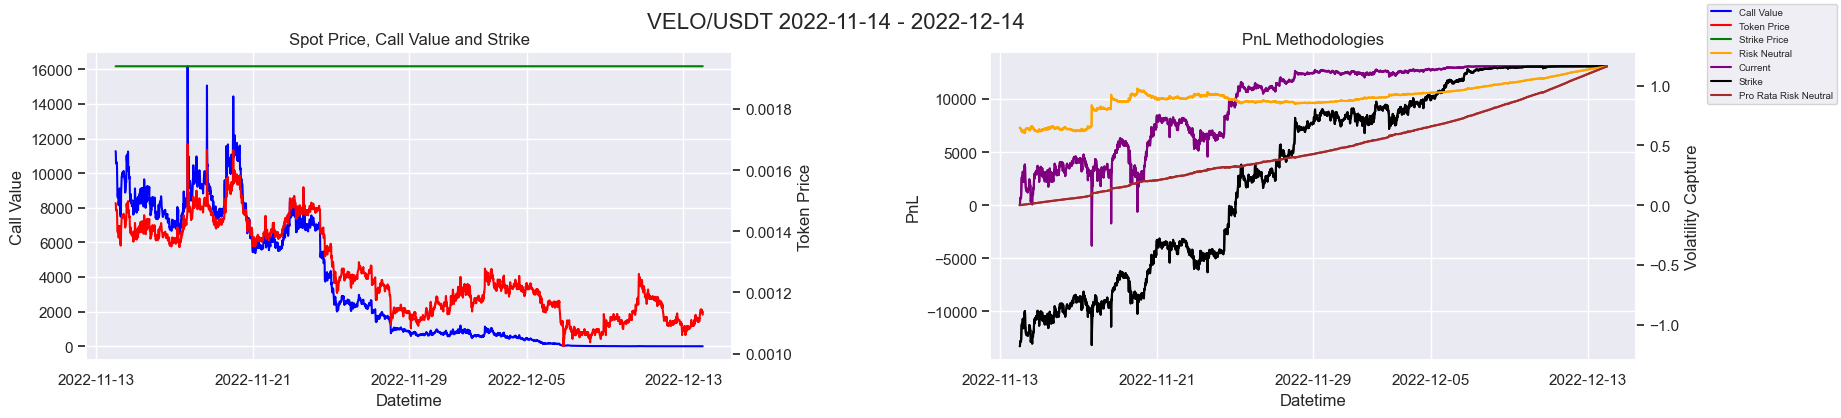

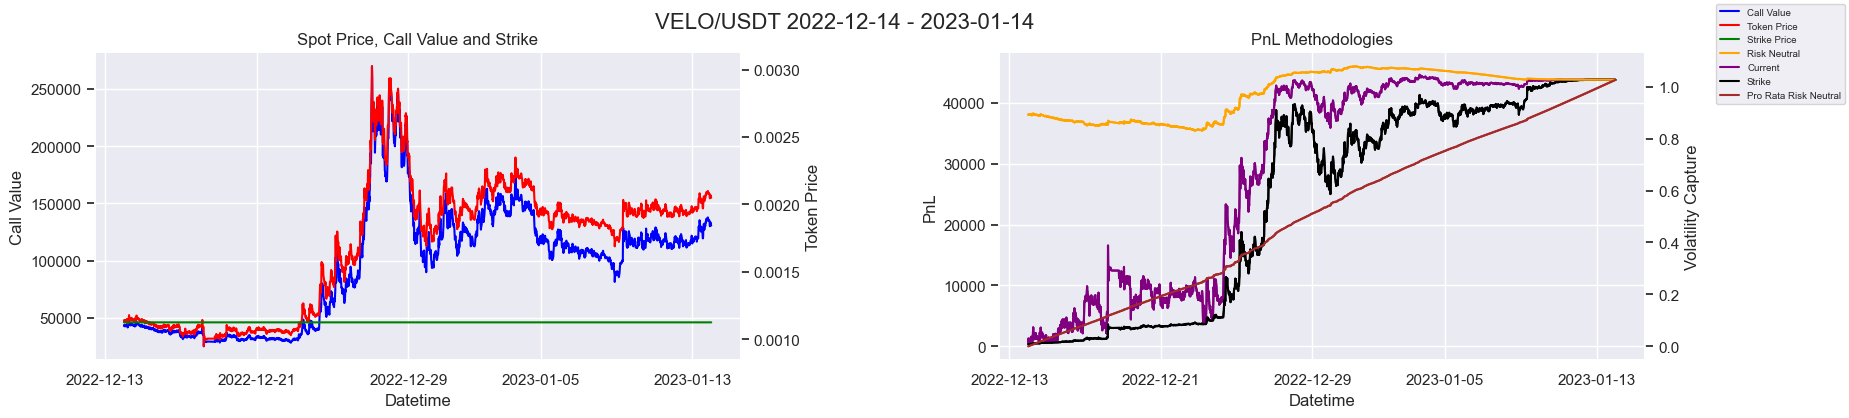

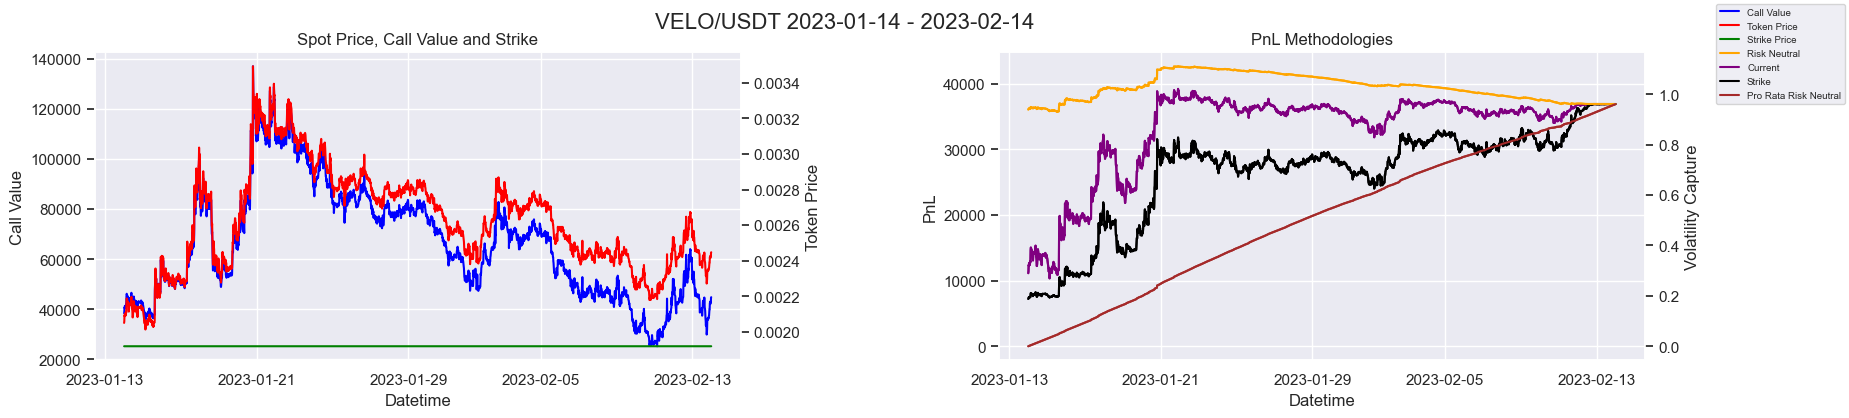

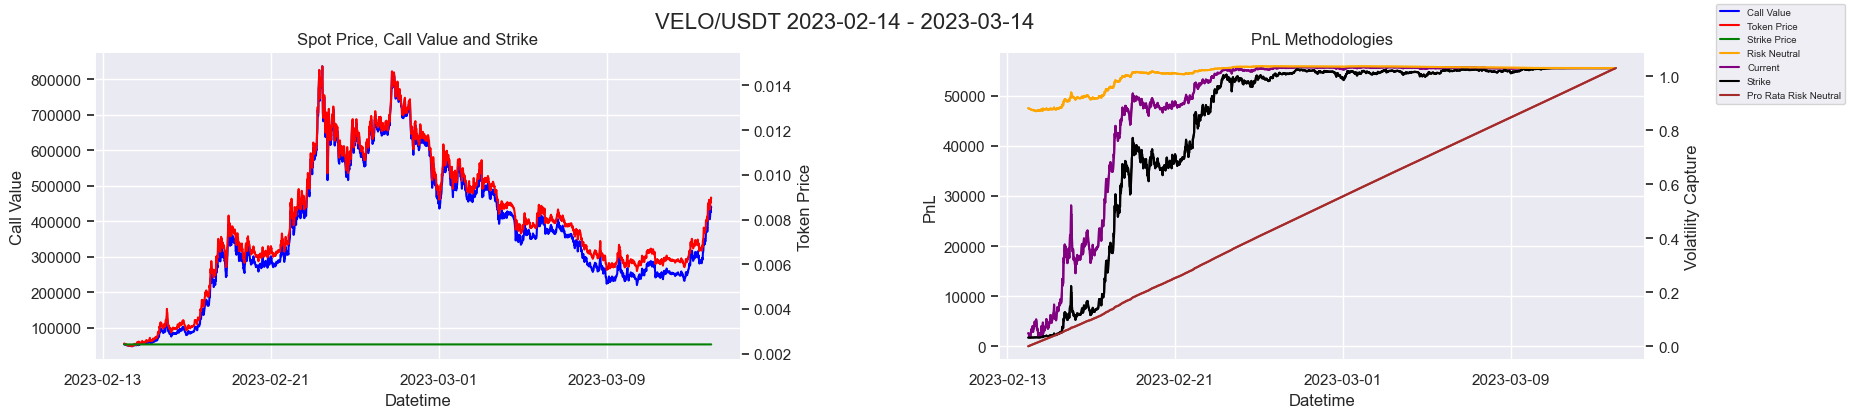

### Theotetical maximum volatility capture:

,base_currency,quote_currency,start_date,end_date,inital_price,strike,volatility_capture
0,ANT,BTC,2022-01-15,2022-07-14,7.923029e-05,1.976650e-04,0.951252
1,ANT,USDT,2022-01-15,2022-07-14,1.601187e+00,8.402857e+00,0.940541
11,ANT,BTC,2022-07-15,2023-01-15,1.274609e-04,7.980000e-05,0.934398
12,ANT,USDT,2022-07-15,2023-01-15,2.672761e+00,1.648571e+00,0.912855
2,CCD,BTC,2022-02-10,2022-08-10,6.581206e-07,1.910000e-06,1.109545
3,CCD,USD,2022-02-11,2022-08-11,1.495000e-02,8.783060e-02,1.083712
4,CCD,USDT,2022-02-11,2022-08-11,1.493442e-02,8.783060e-02,1.076586
13,CCD,BTC,2022-08-10,2023-02-10,4.870737e-07,7.810000e-07,0.889527
14,CCD,USD,2022-08-11,2023-02-11,1.064618e-02,1.804857e-02,0.851748
15,CCD,USDT,2022-08-11,2023-02-11,1.065717e-02,1.804857e-02,0.845008


In [7]:
lltopnl = LLTOptionPnL()
ot_interested, trades_filt = lltopnl.display_pnl_methods(exchange_symbol, interest_rate, minutes)